<h2>OBSERVATIONAL ASTROPHYSICS – FALL 2019 Reduction Exercise: Part 5</h2>

The goal of this part is to produce a color-magnitude diagram for your cluster.  Do do this we need to detect stars, measure their flux, compare it to a known magnitude for that star, derive the magnitude zeropoint for that band, and convert all of your fluxes to magnitudes.  This will be broked into the following steps:

1. read in image with a valid astrometric header (the output image from the end of part 4);
2. Locate stars in this image and measure their flux;
3. Read in an ASCII file with a list of measured magnitudes for stars in that cluster;
4. Cross-match the two lists to find which object corresponds to which;
5. Compare the fluxes and magnitudes to determine the magnitude zeropoint of your image, i.e. what magnitude is a single count;
6. Use this to create magnitudes in each band
7. Produce a color-magnitude diagrame

The first cell below is a routine designed to read in one image

In [31]:
import os, glob, time
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from astropy import units as u


redpath = "/home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/"

A routine to display in image

In [2]:
def display_image(img, minclip=5, maxclip=95, label=None, cmap='Greys_r', 
                  srcs=None, projection=None, calibrated=False):
    """Simple wrapper to display an image.
    
    """
    from astropy.visualization import AsinhStretch as Stretch
    from astropy.visualization import ZScaleInterval as Interval
    from astropy.visualization.mpl_normalize import ImageNormalize

    #from astropy.visualization import simple_norm
    #norm = simple_norm(img, min_percent=minclip, max_percent=maxclip)

    interval = Interval(contrast=0.5)
    vmin, vmax = interval.get_limits(img)
    norm = ImageNormalize(interval=interval, stretch=Stretch(a=0.9))

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': projection})
    im = ax.imshow(img, origin='lower', norm=norm, cmap=cmap,
                   vmin=vmin, vmax=vmax)
    if projection:
        ax.coords.grid(color='red')
        ax.coords['ra'].set_axislabel('Right Ascension')
        ax.coords['dec'].set_axislabel('Declination')      
    else:
        ax.set_xlabel('Column Number (pixels)')
        ax.set_ylabel('Row Number (pixels)')

    # Mark the locations of stars.
    if srcs:
        from photutils import CircularAperture
        pos = np.transpose((srcs['xcentroid'], srcs['ycentroid']))
        aps = CircularAperture(pos, r=12.)
        aps.plot(color='red', lw=1.5, alpha=0.6, axes=ax)
      
    # Make room for the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.28, 0.05, 0.45])
    c = plt.colorbar(im, cax=cax)
    if label:
        c.set_label(label)
    else:
        if calibrated:
            c.set_label(r'Intensity ($e^{-}/s$)')
        else:
            c.set_label('Intensity (ADU)')

<h3> Find the stars in your image</h3>

In [3]:
#filename should be the name of the combined image file (without path) that has the original header
#wcsfilename should be the name of the image that has the correct WCS header, e.g. one output
#by astrometry.net. 
def read_one_image(filename, wcsfilename, redpath):
    from astropy.table import Table
    from astropy.wcs import WCS

    # This joins the path and the filename
    imgfile = os.path.join('{}'.format(redpath), filename)
    wcsfile = os.path.join('{}'.format(redpath), wcsfilename)

    print('Reading {}'.format(imgfile))
    #this is the image and full header of the file.  
    img, hdr = fits.getdata(imgfile, header=True)
    wcshdr = fits.getheader(wcsfile)

    #this is only the section of the file that contains the WCS, which is the mapping between pixel 
    #and sky coordinate (RA,DEC)
    imgwcs = WCS(wcshdr)#, naxis=2)

    return img, hdr, imgwcs, imgfile

In [4]:
img_ngc7128_V, hdr_ngc7128_V, imgwcs_ngc7128_V, imgfile_ngc7128_V = read_one_image('ngc7128_V_comb.fits','wngc7128_V_comb.fits',redpath)
img_ngc7128_B, hdr_ngc7128_B, imgwcs_ngc7128_B, imgfile_ngc7128_B = read_one_image('ngc7128_B_comb.fits','wngc7128_B_comb.fits',redpath)
img_nova_B, hdr_nova_B, imgwcs_nova_B, imgfile_nova_B = read_one_image('nova_B_comb.fits','wnova_B_comb.fits',redpath)
img_nova_V, hdr_nova_V, imgwcs_nova_V, imgfile_nova_V = read_one_image('nova_V_comb.fits','wnova_V_comb.fits',redpath)
img_nova_R, hdr_nova_R, imgwcs_nova_R, imgfile_nova_R = read_one_image('nova_R_comb.fits','wnova_R_comb.fits',redpath)

Reading /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/ngc7128_V_comb.fits
Reading /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/ngc7128_B_comb.fits
Reading /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/nova_B_comb.fits
Reading /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/nova_V_comb.fits
Reading /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/nova_R_comb.fits


This is the same routine that we used in part 4.  It measures the background.

In [5]:
def get_sky_background(img, verbose=True):
    from astropy.stats import SigmaClip
    from photutils import Background2D, MedianBackground
    sigma_clip = SigmaClip(sigma=4.)
    bkg = Background2D(img, (100, 100), filter_size=(10, 10), sigma_clip=sigma_clip, 
                       bkg_estimator=MedianBackground())
    if verbose:
        print('Sky background median = {:.3f}, rms = {:.3f} electrons.'.format(bkg.background_median, bkg.background_rms_median))
    return bkg

This gets the background and subtracts it from the image to get a background subtracted image.  As in part 4 we check that the background looks correct.

In [7]:
#***********
bkg_V = get_sky_background(img_ngc7128_V, verbose=True)
img_ngc7128_V_nosky = img_ngc7128_V - bkg_V.background

bkg_B = get_sky_background(img_ngc7128_B, verbose=True)
img_ngc7128_B_nosky = img_ngc7128_B - bkg_B.background

bkg_B = get_sky_background(img_nova_B, verbose=True)
img_nova_B_nosky = img_nova_B - bkg_B.background

bkg_V = get_sky_background(img_nova_V, verbose=True)
img_nova_V_nosky = img_nova_V - bkg_V.background

bkg_R = get_sky_background(img_nova_R, verbose=True)
img_nova_R_nosky = img_nova_R - bkg_R.background

Sky background median = 3.350, rms = 0.067 electrons.
Sky background median = 3.153, rms = 0.063 electrons.
Sky background median = 3.563, rms = 0.072 electrons.
Sky background median = 3.737, rms = 0.074 electrons.
Sky background median = 6.103, rms = 0.118 electrons.


In [8]:
def qa_background(img,img_nosky,bkg):
    med, sig = bkg.background_median, bkg.background_rms_median
    vrange = (-3*sig, med+5*sig)
    fig, ax = plt.subplots(figsize=(7, 5))
    _ = ax.hist(img.flatten(), bins=100, range=vrange, label='Image w/ Background')
    #_ = ax.hist(bkg.background.flatten(), bins=50, range=(-sig, med+5*sig), label='Background')
    _ = ax.hist(img_nosky.flatten(), bins=100, range=vrange, label='Image w/o Background')
    ax.axvline(x=bkg.background_median, lw=2, ls='-', color='k')
    ax.set_xlabel('Intensity (e-/s)')
    ax.set_ylabel('Number')
    ax.legend(fontsize=12, frameon=False)

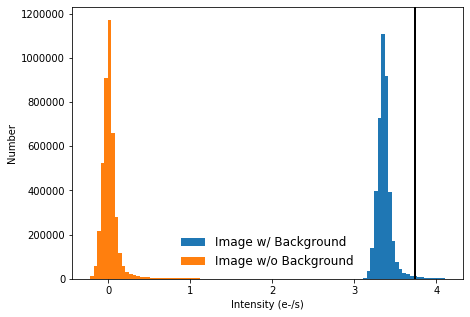

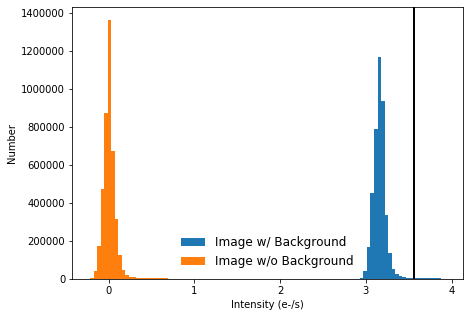

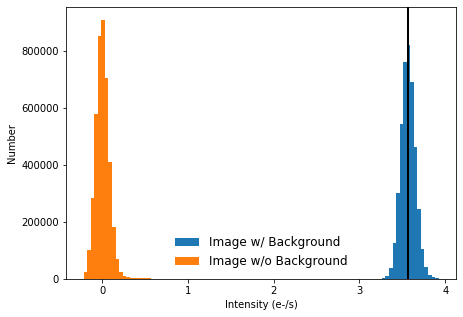

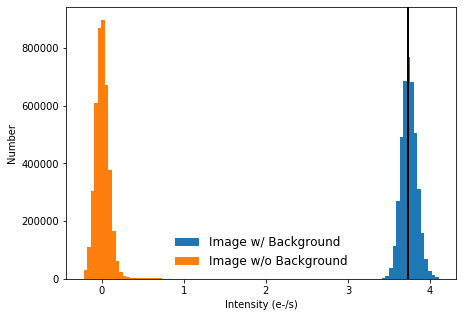

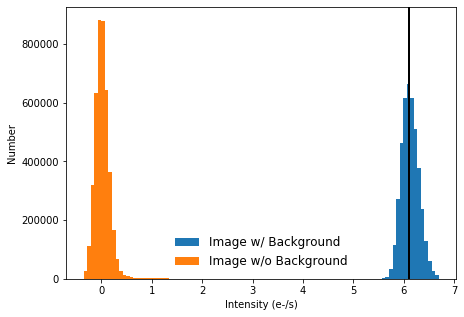

In [9]:
#***********
qa_background(img_ngc7128_V, img_ngc7128_V_nosky,bkg_V)
qa_background(img_ngc7128_B, img_ngc7128_B_nosky,bkg_B)
qa_background(img_nova_B, img_nova_B_nosky,bkg_B)
qa_background(img_nova_V, img_nova_V_nosky,bkg_V)
qa_background(img_nova_R, img_nova_R_nosky,bkg_R)

This routine detects stars in the image.  It requires a zero background image.  There are many ways to measure object flux.  We are using the DAOStarfinder algorithm described (https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html)

This code requires as input the FWHM of stars in the image in pixel units.  You can determine this using the *imexam* task.

You can use this by going to your image directory and typing *ipython* at the command line.  Once the interactive python environment loads you type the following set of commands:

*import imexam*
*viewer=imexam.connect()*
*viewer.load_fits('<filename>')*
*viewer.scale()*
    
You can then hit the "a" key and "r" key on bright isolated and unsaturated stars to find the FWHM.

If imexam doesn't work on your computer then just use the mean FWHM from all the individual observations for that band/target

This will need to be run once for each band

In [10]:
#this code outputs a file with all the detected stars.
#fwhm is for stars in the image in units of pixels
#nsigma is the detection threshold for each star
def find_stars(image, imgfile, fwhm=3.0, nsigma=3, sigma=None, 
               verbose=True, overwrite=False):
    from astropy.table import Table
    
    #this makes a file 
    starsfile = os.path.join(redpath, 'stars-{}'.format(os.path.basename(imgfile)))
    if not os.path.isfile(starsfile) or overwrite:
        from photutils import DAOStarFinder
        if sigma is None:
            sigma = np.std(image)

        daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma * sigma)
        srcs = daofind(image)
        # reverse-sort by flux 
        srcs.sort('flux')
        srcs.reverse()
        if verbose:
            print('Found {} sources'.format(len(srcs)))

        print('Writing {} stars to {}'.format(len(srcs), starsfile))
        srcs.write(starsfile, overwrite=True)
    else:
        srcs = Table.read(starsfile)
        print('Read {} stars from {}'.format(len(srcs), starsfile))
    return srcs

In [11]:
#***********
srcs_ngc7128_V = find_stars(img_ngc7128_V_nosky, imgfile_ngc7128_V, sigma=bkg_V.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_ngc7128_V

Read 1673 stars from /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/stars-ngc7128_V_comb.fits


<Table length=1673>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  203  866.9474044273895 ... 2251.8185919920816     -8.381333501338377
  648 1839.8179399777177 ... 2169.4649546365745      -8.34088159740889
  381 169.74656603571094 ... 2162.0632815681306      -8.33717100299055
  798 2015.3686692213346 ... 2125.8145579192737     -8.318813442113296
 1244 1167.2030411039848 ... 1922.0936785355427     -8.209436375968696
 1115 1237.3416359984042 ... 1821.1058421927894     -8.150837969023915
  794 2015.2342894289632 ... 1712.7050104857403     -8.084206420621005
 1118 1262.4538377934741 ...  1663.555582464525     -8.052593290070057
  662 1856.7922286927803 ...   1578.82839135073     -7.995837318783122
  789 2015.2410018586206 ... 1572.4469235317772     -7.991439987906474
  ...                ... ...                ...                    ...
  463 293.63902331184727 ... 1.0074418893692578  -0.008050012084695714
  286 1574.5661937603747 ... 1.0068450927339692  -0.007406644244335436
  399 187.39020432390438 ... 1.0052134662488534  -0.005645744863014217
  650  226.1634378252556 ... 1.0028862743984281  -0.003129218888279154
  958  1439.317111751117 ... 1.0024972485959494 -0.0027079733770923355
   56 474.02199694937605 ... 1.0015859110828398  -0.001720517146882995
  519 1423.6680816792941 ... 1.0009001999191443 -0.0009769399890287595
 1554  714.2322437210864 ... 1.0008538627444297 -0.0009266741255431433
 1073 1848.8590022013025 ... 1.0004677211766384 -0.0005077030927178261
  713 1615.7725098264552 ... 1.0004668719370555 -0.0005067814732257965

In [12]:
srcs_ngc7128_B = find_stars(img_ngc7128_B_nosky, imgfile_ngc7128_B, sigma=bkg_B.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_ngc7128_B

Read 632 stars from /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/stars-ngc7128_B_comb.fits


<Table length=632>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  471  710.1522730914705 ... 1302.6240309851175     -7.787047714588947
   66  538.8462609498955 ... 1020.7997868772528     -7.522351426762558
  478  838.3264009315924 ...  850.7098602358369     -7.324453666416854
  216 1511.4802239554278 ...  739.4458643588299     -7.172265960805775
  278 1686.9065750339914 ...  632.8429702126938     -7.003239900515598
  363   900.708834133512 ... 443.72316489113854     -6.617780254920675
  426   933.731321098471 ... 438.82809088719193     -6.605736051169732
  419  730.4748794549181 ... 414.03946294182066     -6.542604341456184
  223  1528.441547852228 ...  378.5986132110015     -6.445447547075832
  341  361.0238459197103 ...  375.9670949001215     -6.437874591516981
  ...                ... ...                ...                    ...
  422  980.3310772783522 ... 1.0185968770891543  -0.020005850852541415
  491  790.0638360491272 ...  1.018288369158371   -0.01967695826216623
   59 1029.5762156420978 ...  1.016700584329792    -0.0179826828995147
  393 1438.3671634680284 ...  1.015435113012103  -0.016630442293634043
  137  101.7061666969075 ... 1.0122541076397347  -0.013223869433804485
   61 1029.8174254169946 ... 1.0082940654887287  -0.008968027679577389
  545  884.1392815092463 ... 1.0077437420119115  -0.008375274770156111
  268  749.9917562494401 ... 1.0072829650184763  -0.007878723264345546
  293  853.7367329883051 ... 1.0060341773969503  -0.006531837492543307
  444  795.0603324247154 ... 1.0023632926949568 -0.0025628852088436255

In [13]:
srcs_nova_B = find_stars(img_nova_B_nosky, imgfile_nova_B, sigma=bkg_B.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_nova_B

Read 225 stars from /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/stars-nova_B_comb.fits


<Table length=225>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
   14 1756.6471227394468 ...  643.9002370236138     -7.022046462396519
   12  1755.531672862893 ...   432.011218178898     -6.588737561076259
   11  1756.663388280243 ... 399.78243378644765      -6.50455926886985
   13  1756.963232881974 ...  376.1897134640978    -6.4385172900583765
  143 210.56734353143815 ... 364.16876872803977     -6.403256744430701
  206  594.7930531496596 ... 351.63000967913047     -6.365214831546751
  199 2022.4190732407524 ...  278.9025356811515     -6.113631156831546
  135  264.2219461915301 ...  266.0428859130808      -6.06237912554519
  134  568.9933543961658 ... 232.95123663503597     -5.918162550668979
  146  773.3687331883382 ... 221.85731657270964     -5.865184389423838
  ...                ... ...                ...                    ...
   21 1066.0676798000086 ... 1.0291418710043363   -0.03118811996557143
   87  636.1340017971611 ... 1.0284744486790687  -0.030483766485392375
   80  1629.187394140483 ... 1.0256979583559651  -0.027548727643082922
   18 1020.9508525953338 ... 1.0161244380885421   -0.01736724099653611
   67  1415.252095649149 ... 1.0155766471696563  -0.016781764666381406
   17 1624.0215976153825 ... 1.0136913512466061  -0.014764352840180833
   43  1177.126612971037 ... 1.0124378225458008  -0.013420902792256127
  212  1891.459827360885 ...  1.004949580231444 -0.0053606828077960855
   49   525.857044973423 ... 1.0046294021124493  -0.005014710858686623
   96 393.98782591645147 ... 1.0009027768943672 -0.0009797353843106868

In [14]:
srcs_nova_V = find_stars(img_nova_V_nosky, imgfile_nova_V, sigma=bkg_V.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_nova_V

Read 340 stars from /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/stars-nova_V_comb.fits


<Table length=340>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
   18 1750.4041726054706 ...  623.9192118532975    -6.9878208968111775
  301 2016.2140892120592 ...  444.8983619080603     -6.620652016754916
  309  588.7540772814017 ...   412.247380311899     -6.537894761338987
  308  589.0185257416593 ...  407.0842642615875     -6.524210787903536
  156 1781.9294689691894 ...  405.5795004134448      -6.52018998981276
  307  588.1496662118969 ...  397.4887045253451     -6.498311979449692
  185  562.3607973290273 ...  385.8346530448338     -6.466003076091753
  189  257.9360010026559 ... 381.85295570405066     -6.454740391438408
  205  204.3702261207312 ... 381.48160706867355     -6.453684008799691
  191 258.61144447273983 ... 373.00713196864814     -6.429292839206823
  ...                ... ...                ...                    ...
  188 1683.1913520992891 ...  1.016432009066955  -0.017695833050953035
  300 1287.4046498018006 ... 1.0135123609329317  -0.014572624437953917
   29 1093.8654048175504 ... 1.0107837836687434  -0.011645664442222049
  221 63.526942274957236 ... 1.0098055275900208  -0.010594359143058469
   80 1312.4579603698007 ... 1.0086710914402925  -0.009373935267130715
  139  2044.527964311897 ...   1.00818287802477  -0.008848293848108648
  242 1628.1812088154882 ... 1.0046450054244098  -0.005031573742766997
  324 1254.9840643610555 ... 1.0040637901679443  -0.004403263192529068
   11 1478.9025631616237 ... 1.0020240401720917 -0.0021953527024186708
   17 1629.5588843832984 ... 1.0010171473097214  -0.001103792395120103

In [15]:
srcs_nova_R = find_stars(img_nova_R_nosky, imgfile_nova_R, sigma=bkg_R.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_nova_R

Read 4125 stars from /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/stars-nova_R_comb.fits


<Table length=4125>
  id      xcentroid      ...        flux                  mag          
int64      float64       ...      float64               float64        
----- ------------------ ... ------------------ -----------------------
  323 1743.7791883726031 ... 1308.5266049418897      -7.791956392835225
 3690  581.9476610870538 ... 1291.8537954966864      -7.778033413787899
 2401  556.2247418701112 ... 1208.3534409533327      -7.705484957825103
  295  1743.906813227231 ... 1083.4154167490913      -7.586987528011249
 3656  582.2488199324187 ... 1051.4482558511475      -7.554469762334114
 2524 197.88579220174609 ... 1016.3630608126907      -7.517622181144721
 2017 1775.3793321636751 ...  963.1707825604217      -7.459258249866288
 2497 197.57512874065222 ...  757.9888810269425      -7.199157087483627
 2381 251.47257827093384 ...  726.0666343803557      -7.152441199187303
 2372  556.4365797322125 ...  718.0327742464713      -7.140360669622261
  ...                ... ...                ...                     ...
 3975 2037.4636120485518 ... 1.0003173115107875  -0.0003444619474677863
 2614 1343.1099152082047 ... 1.0002911729067612  -0.0003160909503877566
 1947  592.5728641649506 ... 1.0002819563928624 -0.00030608711431195413
 2785 144.66032673610346 ... 1.0002733000127828 -0.00029669117763430746
 1200 1716.3999575181467 ...  1.000247817209141  -0.0002690307822742555
 4048 1400.3786295844304 ... 1.0001948808773664 -0.00021156860950314298
  583 1996.1553333397114 ... 1.0000632571610377  -6.867841777090416e-05
 3421 1738.3713445893088 ... 1.0000165442948667 -1.7962591330229793e-05
  907 1528.5611429743324 ... 1.0000142404818968 -1.5461296680660873e-05
 1801  1004.074751883256 ... 1.0000073510182654  -7.981237337544668e-06

<h3> Use stars from Pan-STARRS</h3>

We will be using the large survey called Pan-STARRS (https://panstarrs.stsci.edu/).  Pan-STARRS uses SDSS filters (*griz*), which are different from the "Johnson" *BVR* filters that we are using.  But there are transformation between these filters such that if we know the Pan-STARRS magnitudes of a given object, we can determine its B-V color.

This routine sends a request to a catalog server at a remote location and pulls back all the photometry

In [16]:
def get_panstarrs_catalog(imgwcs, radius=0.2, rfaint=17, region=False):
    from astroquery.mast import Catalogs
    ra0, dec0 = imgwcs.wcs.crval
    print('Querying Pan-STARRS catalog with radius={:.3f} deg and central coordinates RA,Dec={:.5f},{:.5f}'.format(
        radius, ra0, dec0))
    if region:
        allcat = Catalogs.query_region('{} {}'.format(ra0, dec0), radius=radius,
                                       catalog='PANSTARRS', data_release='dr2', 
                                       table='mean')#, rMeanPSFMag=[12, 22])
    else:
        allcat = Catalogs.query_criteria(coordinates='{} {}'.format(ra0, dec0), radius=radius,
                                         catalog='PANSTARRS', data_release='dr2', 
                                         table='mean',
                                         columns=['objID', 'raMean', 'decMean',
                                                  'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag'],
                                         gMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         rMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         iMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         zMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         sort_by=[("asc", "rMeanPSFMag")])
    

    #we limit ourselves to bright objects so that we know that they will have high Signal-to-Noise
    rmag = allcat['rMeanPSFMag']
    good = np.isfinite(rmag) * rmag < rfaint
    cat = allcat[good]
    print('Keeping {}/{} Pan-STARRS sources with rmag< {}.'.format(len(cat), len(allcat),rfaint))
    
    #make B and V-band magnitudes using the transformations published in Tonry et al. (2012)
    #https://ui.adsabs.harvard.edu/abs/2012ApJ...750...99T/abstract
    cat['B'] = 0.213 + 0.587 * (cat['gMeanPSFMag'] - cat['rMeanPSFMag']) + cat['gMeanPSFMag'] 
    cat['V'] = 0.006 + 0.474 *  (cat['gMeanPSFMag'] - cat['rMeanPSFMag']) + cat['rMeanPSFMag'] 
    
    return cat

In [17]:
%time refcat_ngc7128_V = get_panstarrs_catalog(imgwcs_ngc7128_V, radius=0.2)
refcat_ngc7128_V

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=326.08522,53.77941


Keeping 887/911 Pan-STARRS sources with rmag< 17.
CPU times: user 378 ms, sys: 77.3 ms, total: 455 ms
Wall time: 13.1 s


<Table masked=True length=887>
      objID           raMean    ...         B                  V         
      int64          float64    ...      float64            float64      
------------------ ------------ ... ------------------ ------------------
172473260768521639 326.07689699 ... 12.996903435707093  12.49050637626648
172353260800752122 326.08018881 ... 13.394347136497498  12.65199419593811
172503258801023374 325.88018571 ... 13.518980298042298 12.710960340499877
172493261417666169 326.14181906 ... 13.128206895828248 12.630714252471924
172643260773104920 326.07735979 ... 13.424496117591858 12.763392126083374
172553259686507433 325.96868718 ... 13.459410614013672 12.773820274353028
172473259798384953 325.97983039 ... 13.340492380142212 12.781784397125245
172633258688450529 325.86897433 ... 13.562148631095885  12.90549631690979
172553264163170669 326.41632148 ... 13.612649194717408 12.930398143768311
172743259826877794 325.98279481 ... 14.018875129699707 13.116250129699708
               ...          ... ...                ...                ...
172483260826960724 326.08266776 ... 18.354912998199463 17.316835578918457
172413263580446644 326.35800778 ... 18.742757459640504  17.43288571548462
172363262159768774  326.2159726 ... 18.674889432907104  17.41387787246704
172573263859626362 326.38594763 ...  18.53606314086914 17.373886459350587
172553263777748239 326.37777166 ...   18.7285239238739  17.43957527542114
172553262697941835 326.26978045 ... 18.772572204589842  17.45357420349121
172523263433159004 326.34331238 ...   18.7647651386261 17.460569972991944
172523260536869365 326.05368032 ... 18.661042865753174 17.431974266052247
172453257754659558 325.77545628 ...  18.75739816093445 17.462997959136963
172493259703374524  325.9703144 ... 18.561794416427613 17.407521213531496

In [18]:
%time refcat_ngc7128_B = get_panstarrs_catalog(imgwcs_ngc7128_B, radius=0.2)
refcat_ngc7128_B

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=326.00712,53.81114
Keeping 851/874 Pan-STARRS sources with rmag< 17.
CPU times: user 29 ms, sys: 4.06 ms, total: 33.1 ms
Wall time: 4.61 s


<Table masked=True length=851>
      objID           raMean    ...         B                  V         
      int64          float64    ...      float64            float64      
------------------ ------------ ... ------------------ ------------------
172473260768521639 326.07689699 ... 12.996903435707093  12.49050637626648
172353260800752122 326.08018881 ... 13.394347136497498  12.65199419593811
172503258801023374 325.88018571 ... 13.518980298042298 12.710960340499877
172493261417666169 326.14181906 ... 13.128206895828248 12.630714252471924
172553259686507433 325.96868718 ... 13.459410614013672 12.773820274353028
172643260773104920 326.07735979 ... 13.424496117591858 12.763392126083374
172473259798384953 325.97983039 ... 13.340492380142212 12.781784397125245
172633258688450529 325.86897433 ... 13.562148631095885  12.90549631690979
172743259826877794 325.98279481 ... 14.018875129699707 13.116250129699708
172473259640020189 325.96395434 ...  13.78830311012268  13.05930626296997
               ...          ... ...                ...                ...
172363259058639985 325.90584764 ...  18.49352724647522  17.35227578353882
172453259870809010 325.98705102 ...  18.37328247833252  17.31895654296875
172393258941603698 325.89413827 ... 18.567522493362425 17.377742015838624
172403260420846772 326.04209213 ...  18.40174561882019 17.328719242095946
172483260826960724 326.08266776 ... 18.354912998199463 17.316835578918457
172683257728582538 325.77285876 ... 18.689186195373534 17.424389541625978
172553262697941835 326.26978045 ... 18.772572204589842  17.45357420349121
172523260536869365 326.05368032 ... 18.661042865753174 17.431974266052247
172453257754659558 325.77545628 ...  18.75739816093445 17.462997959136963
172493259703374524  325.9703144 ... 18.561794416427613 17.407521213531496

In [38]:
%time refcat_nova_B = get_panstarrs_catalog(imgwcs_nova_B, radius=0.2)
refcat_nova_B

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=11.43780,41.88899
Keeping 244/306 Pan-STARRS sources with rmag< 17.
CPU times: user 44.1 ms, sys: 16 µs, total: 44.2 ms
Wall time: 9.01 s


<Table masked=True length=244>
      objID           raMean   ...         B                  V         
      int64          float64   ...      float64            float64      
------------------ ----------- ... ------------------ ------------------
158230116346469361 11.63463808 ... 12.816315893173218 12.311032283782959
158190112505370928 11.25054054 ... 13.302907295227051 12.694114227294921
158090112615613324 11.26158965 ... 14.064754969596862 13.011429971694946
158170112257638375 11.22570264 ... 14.003811842918395 13.044424242019653
158070113119041568 11.31192454 ... 13.685842476844787 13.071484281539917
158210115042413714 11.50424847 ...  14.09989005279541 13.195150665283203
158330115058467558 11.50585428 ...  13.39191865348816 13.058036296844483
158320114124286014 11.41247673 ... 14.179295783996581 13.310951034545898
158080113191887869 11.31922344 ... 13.953713990211487 13.277028066635133
158220113364604669 11.33645339 ...  14.38134712791443 13.426633045196533
               ...         ... ...                ...                ...
158130113969946713 11.39706167 ...  18.07638397026062  17.20881831741333
158330116924372878 11.69244198 ... 18.012890949249268  17.19195858001709
158410115986683433 11.59868919 ... 18.047432876586914 17.202906829833985
158250113058616194 11.30586629 ... 18.173538284301756 17.248988189697265
158280115281875626 11.52821125 ... 18.595150648117066 17.378770496368407
158380116686523686 11.66868025 ...  18.53388628768921  17.36503102874756
158440113558749856 11.35589774 ... 17.926808219909667 17.191355697631835
158130114021155975 11.40213581 ...  18.40371608543396 17.336812091827394
158240115849926644 11.58499626 ... 17.828482271194456 17.186744243621828
158050115426694975  11.5426601 ... 17.753588172912597  17.16549742126465

In [44]:
%time refcat_nova_V = get_panstarrs_catalog(imgwcs_nova_V, radius=0.2)
refcat_nova_V

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=11.35740,41.91078
Keeping 279/350 Pan-STARRS sources with rmag< 17.
CPU times: user 39.3 ms, sys: 0 ns, total: 39.3 ms
Wall time: 8.73 s


<Table masked=True length=279>
      objID           raMean   ...         B                  V         
      int64          float64   ...      float64            float64      
------------------ ----------- ... ------------------ ------------------
158190112505370928 11.25054054 ... 13.302907295227051 12.694114227294921
158420111842767400   11.184552 ... 13.101553148269653 12.650806301116944
158090112615613324 11.26158965 ... 14.064754969596862 13.011429971694946
158400111255916477 11.12564187 ... 13.233314414978027  12.77922827911377
158170112257638375 11.22570264 ... 14.003811842918395 13.044424242019653
158490112615511786 11.26160066 ... 13.502274492263794 12.959148441314698
158210115042413714 11.50424847 ...  14.09989005279541 13.195150665283203
158070113119041568 11.31192454 ... 13.685842476844787 13.071484281539917
158460112728996510 11.27293783 ... 13.728125076293946 13.103750076293945
158330115058467558 11.50585428 ...  13.39191865348816 13.058036296844483
               ...         ... ...                ...                ...
158360114652652891 11.46530952 ... 18.141047258377075 17.224065227508547
158320113319682519 11.33199632 ...  17.80016596221924 17.122812393188475
158260115951685303 11.59518325 ... 18.554329650878906 17.349746337890625
158130113969946713 11.39706167 ...  18.07638397026062  17.20881831741333
158250113058616194 11.30586629 ... 18.173538284301756 17.248988189697265
158280115281875626 11.52821125 ... 18.595150648117066 17.378770496368407
158440113558749856 11.35589774 ... 17.926808219909667 17.191355697631835
158130114021155975 11.40213581 ...  18.40371608543396 17.336812091827394
158190111225292846 11.12254286 ...  18.21460410499573 17.290497692108154
158240115849926644 11.58499626 ... 17.828482271194456 17.186744243621828

In [52]:
%time refcat_nova_R = get_panstarrs_catalog(imgwcs_nova_R, radius=0.2)
refcat_nova_R

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=11.35740,41.91055
Keeping 278/349 Pan-STARRS sources with rmag< 17.
CPU times: user 41.6 ms, sys: 92 µs, total: 41.7 ms
Wall time: 9.43 s


<Table masked=True length=278>
      objID           raMean   ...         B                  V         
      int64          float64   ...      float64            float64      
------------------ ----------- ... ------------------ ------------------
158190112505370928 11.25054054 ... 13.302907295227051 12.694114227294921
158420111842767400   11.184552 ... 13.101553148269653 12.650806301116944
158090112615613324 11.26158965 ... 14.064754969596862 13.011429971694946
158400111255916477 11.12564187 ... 13.233314414978027  12.77922827911377
158170112257638375 11.22570264 ... 14.003811842918395 13.044424242019653
158490112615511786 11.26160066 ... 13.502274492263794 12.959148441314698
158070113119041568 11.31192454 ... 13.685842476844787 13.071484281539917
158210115042413714 11.50424847 ...  14.09989005279541 13.195150665283203
158460112728996510 11.27293783 ... 13.728125076293946 13.103750076293945
158330115058467558 11.50585428 ...  13.39191865348816 13.058036296844483
               ...         ... ...                ...                ...
158360114652652891 11.46530952 ... 18.141047258377075 17.224065227508547
158320113319682519 11.33199632 ...  17.80016596221924 17.122812393188475
158260115951685303 11.59518325 ... 18.554329650878906 17.349746337890625
158130113969946713 11.39706167 ...  18.07638397026062  17.20881831741333
158250113058616194 11.30586629 ... 18.173538284301756 17.248988189697265
158280115281875626 11.52821125 ... 18.595150648117066 17.378770496368407
158440113558749856 11.35589774 ... 17.926808219909667 17.191355697631835
158130114021155975 11.40213581 ...  18.40371608543396 17.336812091827394
158190111225292846 11.12254286 ...  18.21460410499573 17.290497692108154
158240115849926644 11.58499626 ... 17.828482271194456 17.186744243621828

We need to match the Pan-STARRS catalog against ours.  First we need to compute the nearest Pan-STARRS star to each of ours and look at the distribution of distances to find the optimal match.

In [20]:
def sep_check(imgwcs,srcs,refcat):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    
    #this makes an instance of a SkyCoord class containing the RAs and Decs from Pan-STARRS objects
    refcoord = SkyCoord(ra=refcat['raMean']*u.deg, dec=refcat['decMean']*u.deg)
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars = imgwcs.all_pix2world(srcs['xcentroid']+1, srcs['ycentroid']+1, 1)
    #this does the same from our targets 
    coord = SkyCoord(ra=radec_stars[0]*u.deg, dec=radec_stars[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord.match_to_catalog_sky(refcoord)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    return refcoord, coord

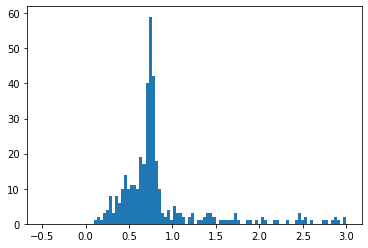

In [21]:
refcoord_ngc7128_V, coord_ngc7128_V = sep_check(imgwcs_ngc7128_V,srcs_ngc7128_V,refcat_ngc7128_V)

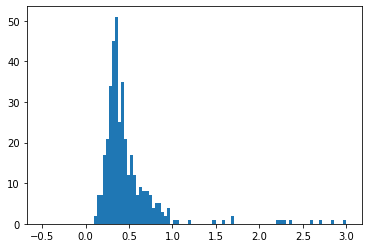

In [22]:
refcoord_ngc7128_B, coord_ngc7128_B = sep_check(imgwcs_ngc7128_B,srcs_ngc7128_B,refcat_ngc7128_B)

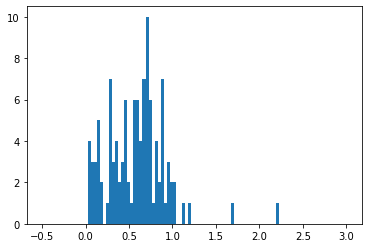

In [41]:
refcoord_nova_B, coord_nova_B = sep_check(imgwcs_nova_B,srcs_nova_B,refcat_nova_B)

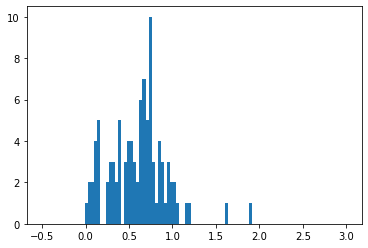

In [45]:
refcoord_nova_V, coord_nova_V = sep_check(imgwcs_nova_V,srcs_nova_V,refcat_nova_V)

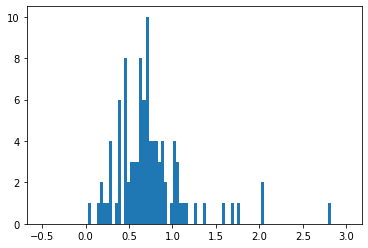

In [53]:
refcoord_nova_R, coord_nova_R = sep_check(imgwcs_nova_R,srcs_nova_R,refcat_nova_R)

It looks like the optimal match is less than 1.0 arcsec.  The following routine matches to within this tolerance

In [28]:
#take two lists of coordinates 
def match_src_ref(refcoord, coord, srcs, img, radasec = 1.0):
    rad = radasec * u.arcsec

    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_ref, indx, d2d, _ = coord.search_around_sky(refcoord, rad)
    nmatch = len(indx_ref)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs), rad))
    display_image(img, srcs=srcs[indx], calibrated=True)
    return indx, indx_ref

Found 317/1673 stars within 1.0 arcsec
Found 368/632 stars within 1.0 arcsec
Found 104/225 stars within 1.0 arcsec
Found 90/340 stars within 1.0 arcsec
Found 82/4125 stars within 1.0 arcsec


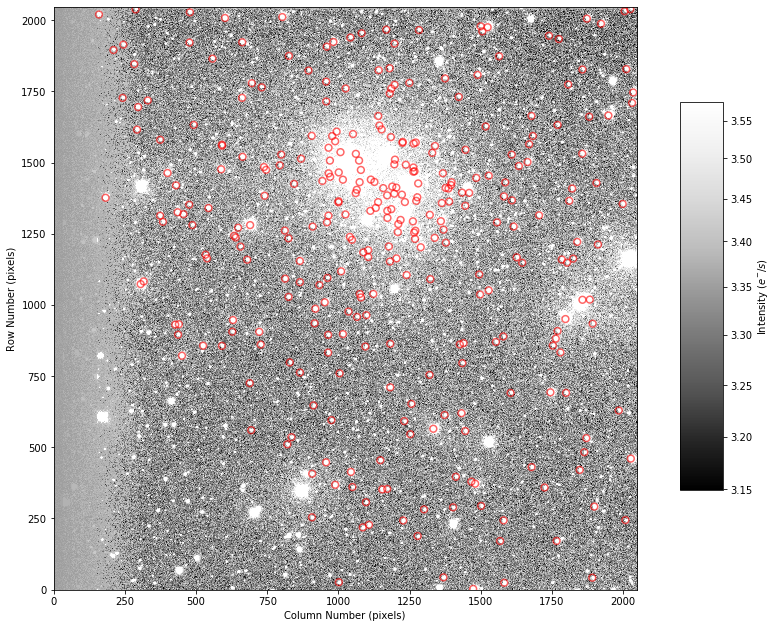

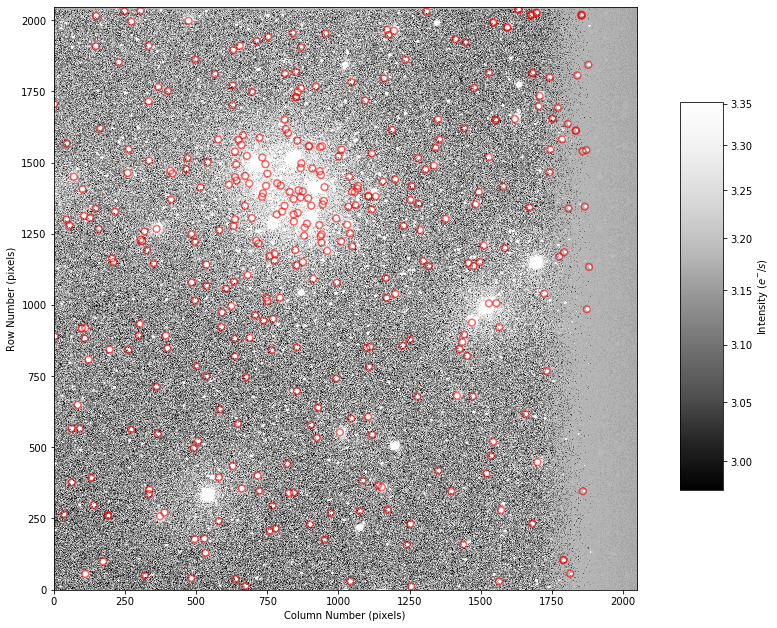

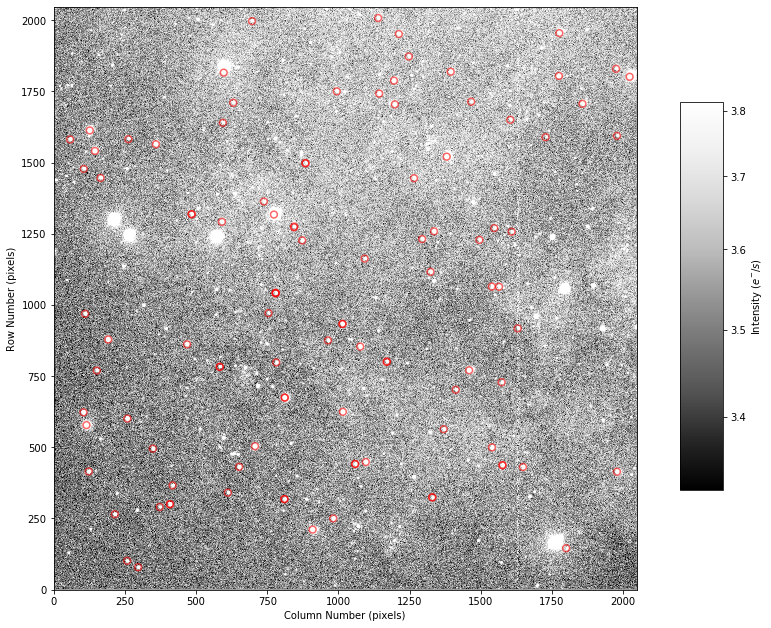

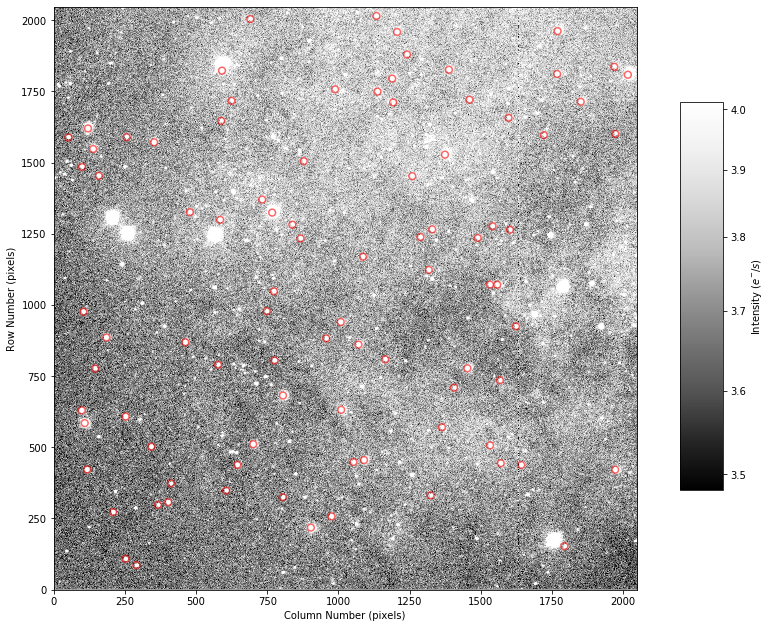

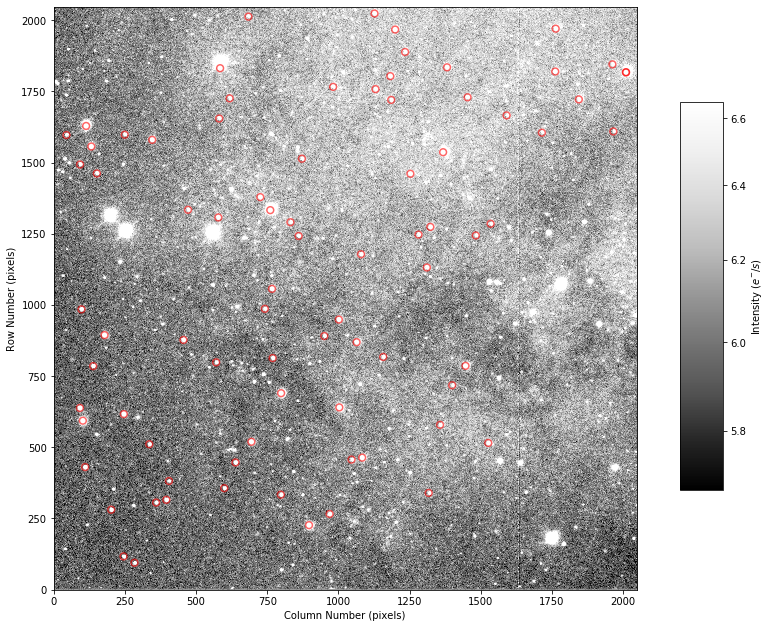

In [54]:
indx_ngc7128_V, indx_ref_ngc7128_V = match_src_ref(refcoord_ngc7128_V, coord_ngc7128_V, srcs_ngc7128_V, img_ngc7128_V)
indx_ngc7128_B, indx_ref_ngc7128_B = match_src_ref(refcoord_ngc7128_B, coord_ngc7128_B, srcs_ngc7128_B, img_ngc7128_B)
indx_nova_B, indx_ref_nova_B = match_src_ref(refcoord_nova_B, coord_nova_B, srcs_nova_B, img_nova_B)
indx_nova_V, indx_ref_nova_V = match_src_ref(refcoord_nova_V, coord_nova_V, srcs_nova_V, img_nova_V)
indx_nova_R, indx_ref_nova_R = match_src_ref(refcoord_nova_R, coord_nova_R, srcs_nova_R, img_nova_R)

Now let's calculate the zeropoints for each image.  To compare our objects to those from Pan-STARRS we will need to correct for the effects of airmass.

We start by specifying the atmospheric extinction coefficient for each object.  This says for a typical atmosphere, how much the magnitude changes for an increase in airmass of 1.  We could have measured this using mutliple standard stars but will just assume a cannonical value for now.

In [67]:
def zp_meas(srcs, refcat, indx, indx_ref, hdr):
    kext = {'B': 0.4, 'V': 0.2}
    import numpy.ma as ma

    #this consists of the instrumental magnitude, which is the magnitude, including an airmass correction
    #but without a true zeropoint.  The second term says how the magnitude 
    #m(inst) = -2.5 * log(flux) - (sec z) * k
    instmag = srcs['mag'][indx].data - hdr['AIRMASS'] * kext[hdr['FILTER']]

    #the Pan-STARRS magnitudes for the same objects, as indicated using the indx_ref array
    psmag = refcat[hdr['FILTER']][indx_ref].data

    #calculate the median zeropoint defined as
    #psmag = -2.5 * log(flux) - (sec z) * k + ZP = m(inst) + ZP
    medzp = np.median(psmag - instmag)
    print(hdr['FILTER'],'zeropoint = ', medzp)
    print('Airmass in {} was {}'.format(hdr['FILTER'], hdr['AIRMASS']))
    return medzp

In [69]:
ZPV = zp_meas(srcs_ngc7128_V,refcat_ngc7128_V, indx_ngc7128_V, indx_ref_ngc7128_V,hdr_ngc7128_V)
ZPB = zp_meas(srcs_ngc7128_B,refcat_ngc7128_B, indx_ngc7128_B, indx_ref_ngc7128_B,hdr_ngc7128_B)
ZPB = zp_meas(srcs_nova_B,refcat_nova_B, indx_nova_B, indx_ref_nova_B,hdr_nova_B)
ZPB = zp_meas(srcs_nova_V,refcat_nova_V, indx_nova_V, indx_ref_nova_V,hdr_nova_V)
#ZPB = zp_meas(srcs_nova_R,refcat_nova_R, indx_nova_R, indx_ref_nova_R,hdr_nova_R)
#R isn't needed for the CMD's, so because of the weird R_JOHN error I stop with the R here.

V zeropoint =  20.46537652181884
Airmass in V was 1.217104
B zeropoint =  20.0979449243299
Airmass in B was 1.163366
B zeropoint =  19.104961661431716
Airmass in B was 1.098645
V zeropoint =  18.794686042635
Airmass in V was 1.129516


Now match the B and V-band catalogs together for this cluster, apply the zeropoints, and plot a CMD!

In [36]:
def make_CMD(img_B,imgwcs_B,srcs_B,imgwcs_V,srcs_V, hdr_B, hdr_V, ZPB, ZPV, radasec = 1.0):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    import numpy.ma as ma
    kext = {'B': 0.4, 'V': 0.2}
    rad = radasec * u.arcsec
    
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars_B = imgwcs_B.all_pix2world(srcs_B['xcentroid']+1, srcs_B['ycentroid']+1, 1)
    radec_stars_V = imgwcs_V.all_pix2world(srcs_V['xcentroid']+1, srcs_V['ycentroid']+1, 1)
    #this makes an instance of a SkyCoord class containing the RAs and Decs from the B-band
    coord_B = SkyCoord(ra=radec_stars_B[0]*u.deg, dec=radec_stars_B[1]*u.deg)
    coord_V = SkyCoord(ra=radec_stars_V[0]*u.deg, dec=radec_stars_V[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord_B.match_to_catalog_sky(coord_V)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    plt.xlabel('Sep between B and V sources [arcsec]',fontsize=14)
    plt.ylabel('N',fontsize=14)


    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_B, indx_V, d2d, _ = coord_V.search_around_sky(coord_B, rad)
    nmatch = len(indx_B)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs_B), rad))
    display_image(img_B, srcs=srcs_B[indx_B], calibrated=True)
    
    #make the B and V-band magnitudes
    magB = srcs_B['mag'][indx_B].data + ZPB - hdr_B['AIRMASS'] * kext[hdr_B['FILTER']]
    magV = srcs_V['mag'][indx_V].data + ZPV - hdr_V['AIRMASS'] * kext[hdr_V['FILTER']]
    #print(magB)
    #print(magV)
    #print(magB-magV)

    #plot the CMD!
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(magB-magV, magV, 'ro',alpha=0.7)
    ax.set_ylim(19,10)
    ax.set_xlabel('B-V',fontsize=18)
    ax.set_ylabel('V',fontsize=18)
    plt.show


Found 584/632 stars within 1.0 arcsec


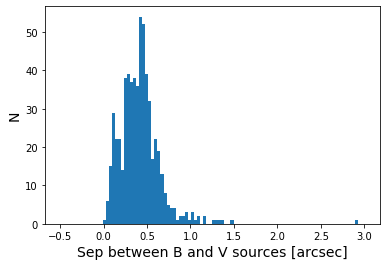

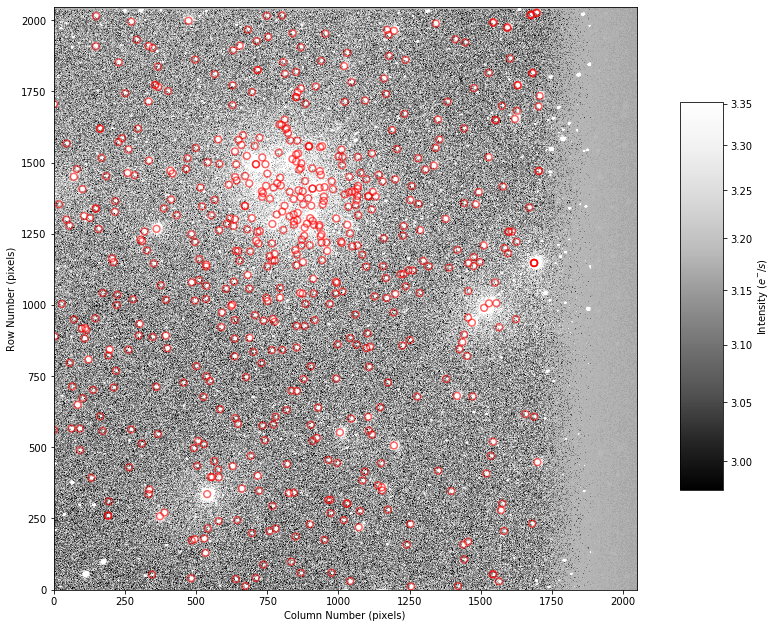

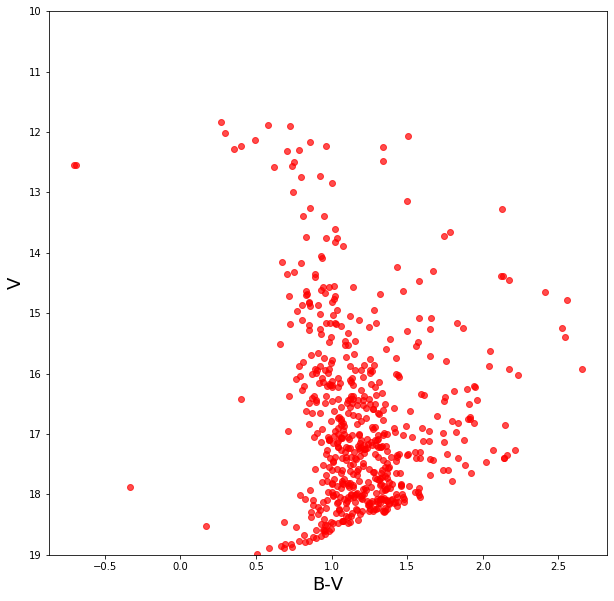

In [37]:
make_CMD(img_ngc7128_B, imgwcs_ngc7128_B, srcs_ngc7128_B,imgwcs_ngc7128_V, srcs_ngc7128_V, hdr_ngc7128_B, hdr_ngc7128_V, ZPB, ZPV, radasec = 1.0)

Found 192/225 stars within 1.0 arcsec


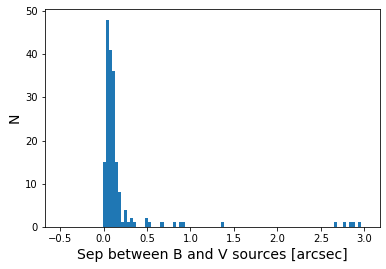

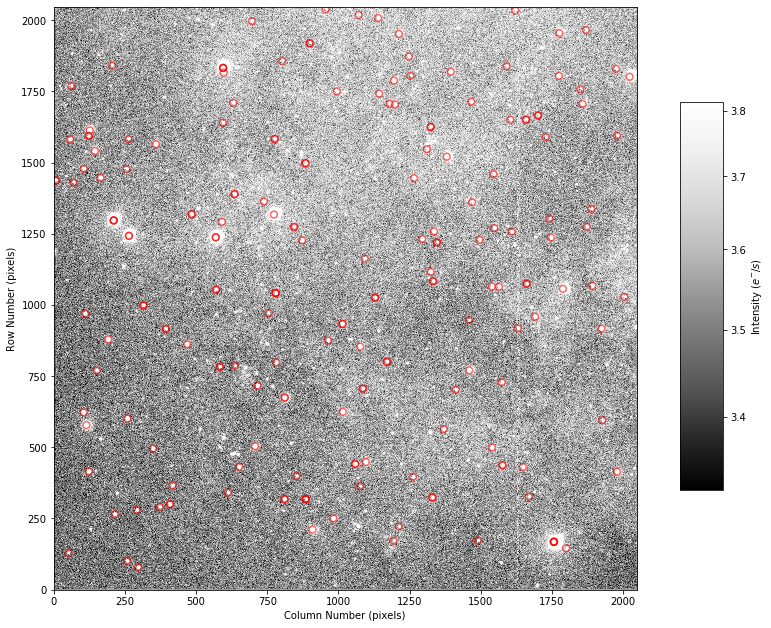

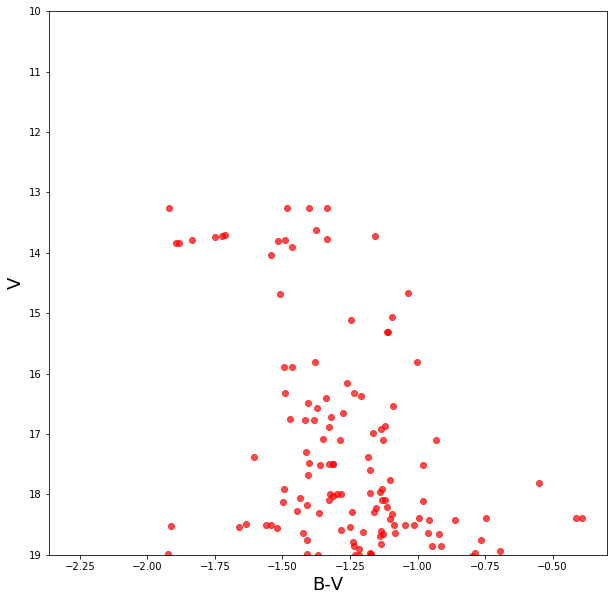

In [51]:
make_CMD(img_nova_B, imgwcs_nova_B, srcs_nova_B,imgwcs_nova_V, srcs_nova_V, hdr_nova_B, hdr_nova_V, ZPB, ZPV, radasec = 1.0)